In [19]:
import numpy as np
%matplotlib notebook

import matplotlib.pyplot as plt
import csv
from collections import Counter, defaultdict
from matplotlib.pyplot import cm
import math

# Can change this to ./data/acl-mainconfs-from2010.csv when we've settled on which statistical tests to run
DATAFILE="./data/acl-evenyears.csv"

In [20]:
def parse_csv(filename, age_limit=None):
    '''
    A custom CSV parsing function to process the data in the Marcel format
    
    TODO: Make it possible to store the citations of each conference in their own data structure
    '''
    counters = defaultdict(Counter)  # We store the counts of publications in a dictionary, one per conference year
    with open(filename) as csvfile:
        reader = csv.reader(csvfile, delimiter='\t')

        for row in reader:
            paper_id = row[0]
            year = int(row[1])
            citations = row[2].split(',')
            if len(citations) <= 1:
                # Front matter or articles that otherwise failed to parse any citations
                continue
            citations = [int(x) for x in citations]
            ages = [year - x for x in citations]

            for a in ages:
                if age_limit == None:
                    counters[year][a] += 1
                elif a < 0:
                    # Don't plot citations of papers that will be published in the future
                    continue
                elif abs(a) <= age_limit:
                    counters[year][a] += 1
    return counters

In [21]:
def mulitple_plots(counters):
    '''
    Create one plot for each year in the citation Counter object
    '''
    fig, axs = plt.subplots(len(counters))
    i = 0
    color = iter(cm.rainbow(np.linspace(0,1,len(counters))))
    for c in counters:
        this_color = next(color)
        sorted_counter = sorted(counters[c].items(), key=lambda pair: pair[0])
        x = [x[0] for x in sorted_counter]
        y = [x[1] for x in sorted_counter]
        sumy = sum(y)
        y = [q/sumy for q in y]  # normalise
        axs[i].plot(x, y, label=c, color=this_color)
        axs[i].legend(loc='upper right')
        i += 1

    plt.xlabel('Age = Published Year -  Citation year')
    
def single_plot(counters):
    '''
    Create a single plot that puts the data for all years onto a single plot
    '''
    fig, axs = plt.subplots(1)
    color = iter(cm.rainbow(np.linspace(0,1,len(counters))))
    for c in counters:
        this_color = next(color)
        sorted_counter = sorted(counters[c].items(), key=lambda pair: pair[0])
        x = [x[0] for x in sorted_counter]
        y = [x[1] for x in sorted_counter]
        sumy = sum(y)
        y = [q/sumy for q in y]  # normalise
        axs.plot(x, y, label=c, color=this_color)
    axs.legend(loc='upper right')
    plt.xlabel('Age = Published Year -  Citation year')

<IPython.core.display.Javascript object>


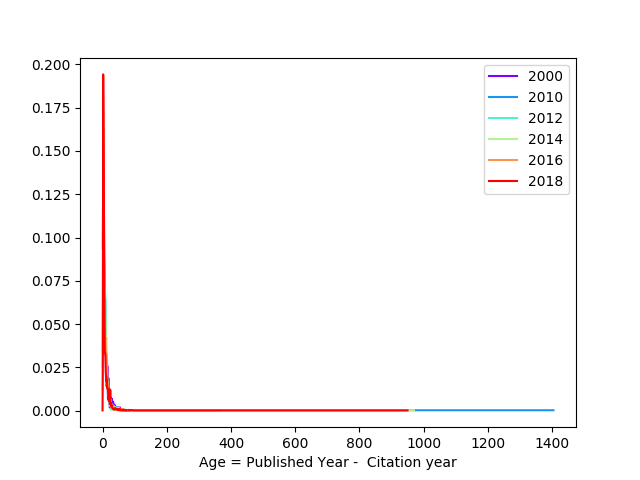

In [11]:
counters = parse_csv(DATAFILE)
single_plot(counters)

<IPython.core.display.Javascript object>


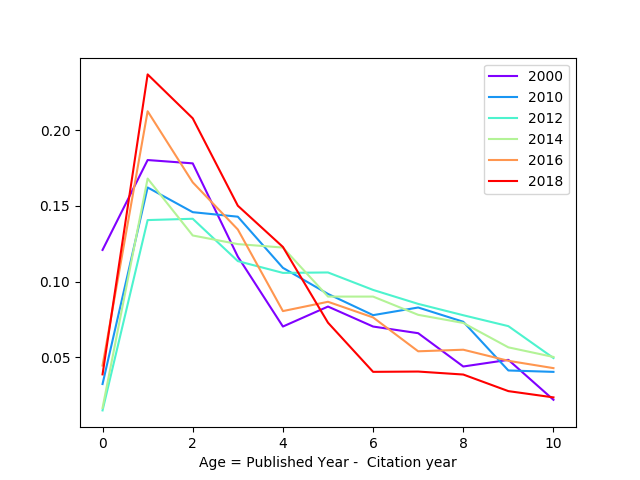

In [12]:
ten_year_counters = parse_csv(DATAFILE, age_limit=10)
single_plot(ten_year_counters)

Let's restrict ourselves to citations from the last 50 years, as the curves are pretty much flat after that.  Also, while working on the small "ACL in even years" dataset, let's take out the year 2000 as it is less reliable and creates a large gap between it and the remaining years.

<IPython.core.display.Javascript object>


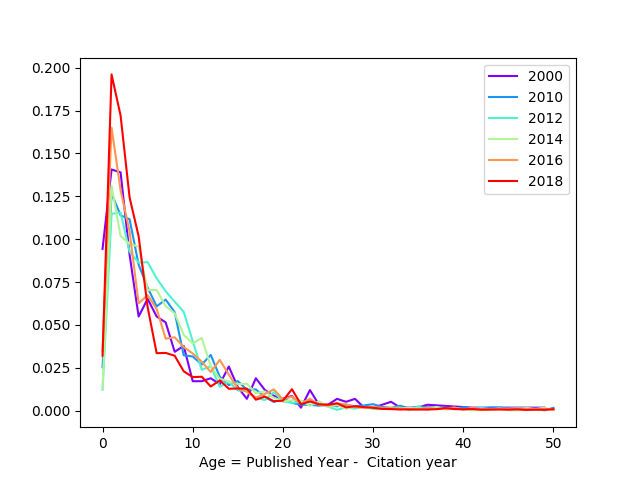

In [22]:
fifty_year_counters = parse_csv(DATAFILE, age_limit=50)
single_plot(fifty_year_counters)